<div >
<img src = "figs/ans_banner_1920x200.png" />
</div>

# Caso-taller:  Recomendando Música

El objetivo de este caso-taller es construir un sistema de recomendación de Música utilizando los datos de [Last.fm](https://www.last.fm/) provistos  abiertamente por [grouplens](https://grouplens.org/about/what-is-grouplens/) para: **"avanzar la teoría y la práctica de la computación social mediante la construcción y la comprensión de sistemas *(de recomendación)* utilizados por personas reales".**

Los datos contienen información sobre artistas, usuarios, y las veces que estos escucharon sus canciones. Las bases se encuentran en los `Archivos de Laboratorio` en la carpeta `data`, allí también está disponible un archivo [README](data/readme.txt) que contiene más información sobre las bases.


## Instrucciones generales

1. Para desarrollar el *cuaderno*, primero debe descargarlo.

2. Para responder cada inciso deberá utilizar el espacio debidamente especificado.

3. La actividad será calificada sólo si sube el *cuaderno* de jupyter notebook con extensión `.ipynb` en la actividad designada como "entrega calificada por el personal".

4. El archivo entregado debe poder ser ejecutado localmente por el tutor. Sea cuidadoso con la especificación de la ubicación de los archivos de soporte, guarde la carpeta de datos en el mismo `path` de su cuaderno, por ejemplo: `data`.

## Desarrollo


### 1. Carga de datos 

En la carpeta `data` se encuentran los archivos:

   - `artists.dat`  que contienen el identificador del artista (`id`), nombre (`name`), link a la página del artista en last.fm (`url`), y link a la imagen del usuario (`pictureURL`), vale aclarar que varios de estos links están rotos. 
   - `user_artists.dat`  que contiene identificador del usuario (`userID`), nombre del artista que escuchó (`artistID`), y las veces que los escuchó (`weight`).

Cargue estos datos en su *cuaderno*:

   1. Para la base de artistas seleccione las columnas de identificador de artista (`id`) y nombre (`name`). Renombre estas columnas para poder hacer la unión con la base `user_artists.dat`.
   2. Para la base de usuarios y artistas, renombre las columnas de forma tal que se mantenga la consistencia para unir con la base anterior, y renombre la columna `weight` a `nro_reproducciones`.
   3. Una estas bases.
   

In [99]:
# Importar librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import apyori as ap
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from scipy.linalg import svd

In [100]:
# Cargar datos de artistas
df_artists = pd.read_csv('./data/artists.dat', sep='\t')
df_artists.rename(columns={'id': 'artistID'}, inplace=True)
df_artists.drop(columns=['url', 'pictureURL'], inplace=True)

# Cargar datos de usuarios
df_users = pd.read_csv('./data/user_artists.dat', sep='\t')
df_users.rename(columns={'weight': 'nro_reproducciones'}, inplace=True)

# Unir la bases
df = pd.merge(df_users, df_artists, on='artistID')
df.head()

,userID,artistID,nro_reproducciones,name
0,2,51,13883,Duran Duran
1,4,51,228,Duran Duran
2,27,51,85,Duran Duran
3,28,51,10,Duran Duran
4,62,51,528,Duran Duran


El primer paso es importar las librerías que se van a necesitar en este notebook. Seguido a esto se procede a leer los archivos de artistas y usuarios renombrando la columna 'id' de la base de artistas a 'artistsID' y removiendo las columnas de las urls que no se van a necesitar. Finalmente, se unen los dos dataframes en la columna de 'artistsID'.

### 2. Análisis preliminar. 

En esta sección exploraremos la base. Para ello responda las siguientes preguntas.

#### 2.1 ¿Cuantos usuarios y artistas hay en la base?



#### 2.2 ¿Cuáles es la distribución de probabilidad del consumo por artista? (haga el calculo sin ponderar y ponderando por el numero de reproducciones) ¿Qué podemos inferir a partir de la comparación de ambas?

In [101]:
# Calcular cuántos usuarios y artistas hay
total_users = df.userID.nunique()
total_artists = df.artistID.nunique()

print(f'Hay {total_users} usuarios y {total_artists} artistas')

# Calcular la distribución de probabilidad de consumo por artista
df_artist_consumption = df.groupby('artistID').agg({'userID': 'count'})
df_artist_w_consumption = df.groupby('artistID').agg({'nro_reproducciones': 'sum'})

Hay 1892 usuarios y 17632 artistas


C:\Users\Daniel Rozo\AppData\Local\Temp\ipykernel_13968\2726431774.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_artist_consumption['prob'], ax=ax[0])
C:\Users\Daniel Rozo\AppData\Local\Temp\ipykernel_13968\2726431774.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_artist_w_con

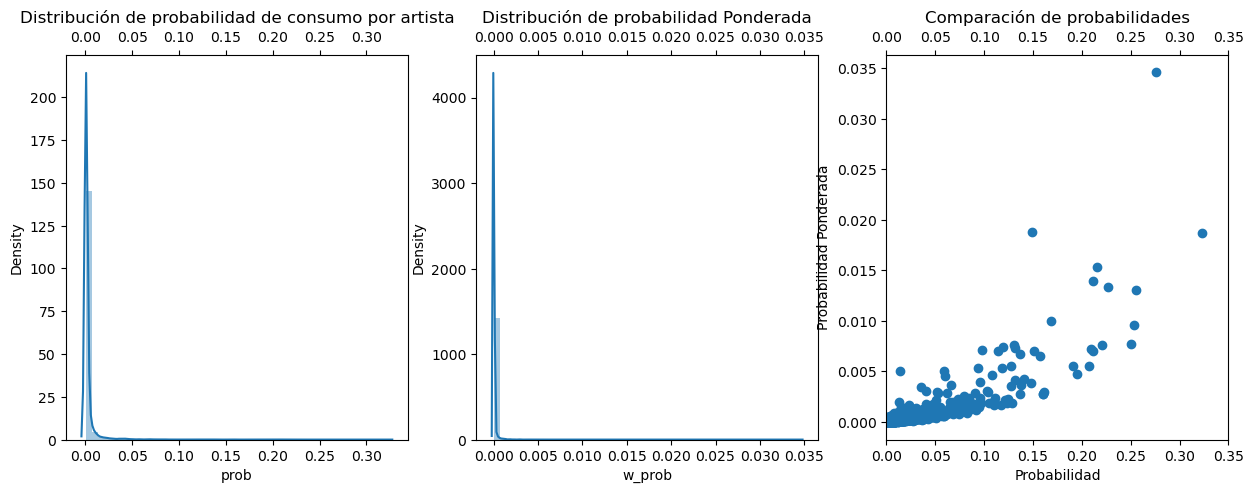

In [102]:
# Agregar la columna de nombre de artista
df_artist_consumption = pd.merge(df_artist_consumption, df_artists, on='artistID')
df_artist_consumption.rename(columns={'userID': 'users_consumption'}, inplace=True)
df_artist_w_consumption = pd.merge(df_artist_w_consumption, df_artists, on='artistID')

# Calcular la probabilidad de consumo
df_artist_consumption['prob'] = df_artist_consumption['users_consumption'] / total_users
df_artist_w_consumption['w_prob'] = df_artist_w_consumption['nro_reproducciones'] / df_artist_w_consumption['nro_reproducciones'].sum()

# Unir probabilidades
df_probs = pd.merge(df_artist_consumption, df_artist_w_consumption[['artistID','w_prob']], on='artistID', how='inner')

# Graficar la distribución de probabilidad de consumo
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.distplot(df_artist_consumption['prob'], ax=ax[0])
ax[0].set_title('Distribución de probabilidad de consumo por artista')
sns.distplot(df_artist_w_consumption['w_prob'], ax=ax[1])
ax[1].set_title('Distribución de probabilidad Ponderada')
ax[2].set_title('Comparación de probabilidades')
ax[2].scatter(df_probs['prob'], df_probs['w_prob'])
plt.xlabel('Probabilidad')
plt.ylabel('Probabilidad Ponderada')
plt.xlim(0, 0.35)
plt.show()

Graficando las probabilidades simples, se puede observar que el "número de casos exitosos" para cada artista es más homogéneo entre artistas y por ende el eje y muestra que hay una menor frecuencia para cada artista en comparación con el eje y de la gráfica de las probabilidades ponderadas. Para esta segunda gráfica se puede ver cómo el 'share market' de cada artista se ve reflejado pues para los artistas más famosos no cuenta simplemente el hecho de que la mayoría de gente los escucha sino también cuántas veces son escuchados por toda esta población, haciendo que para artistas menos reconocidos exista una menor probabilidad de consumo pues en este caso el "número de casos exitosos" debe considerar todas las reproducciones totales y no solo si existe una persona que escucha al artista. Finalmente, en la tercera gráfica se comparan ambas probabilidades ratificando las conclusiones expuestas pues, de no haber diferencia entre estas, se debería graficar una línea recta, pero como se puede ver, hay casos en el que la probabilidad ponderada es mucho mayor y esto se debe a que tienen un share grande del mercado, es decir, son escuchados con mucha más frecuencia que el resto de artistas.

#### 2.3 Para el usuario 8 (`userID==8`) ¿cuál es la distribución de reproducción de artistas basado en el número de reproducciones relativas?. Presente sus resultados usando tablas y/o gráficas. ¿Encuentra algún patrón en los artistas que escucha y las veces que reproduce? ¿Podemos decir algo de sus preferencias?


C:\Users\Daniel Rozo\AppData\Local\Temp\ipykernel_13968\4205498852.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user8.sort_values(by='nro_reproducciones', ascending=False, inplace=True)


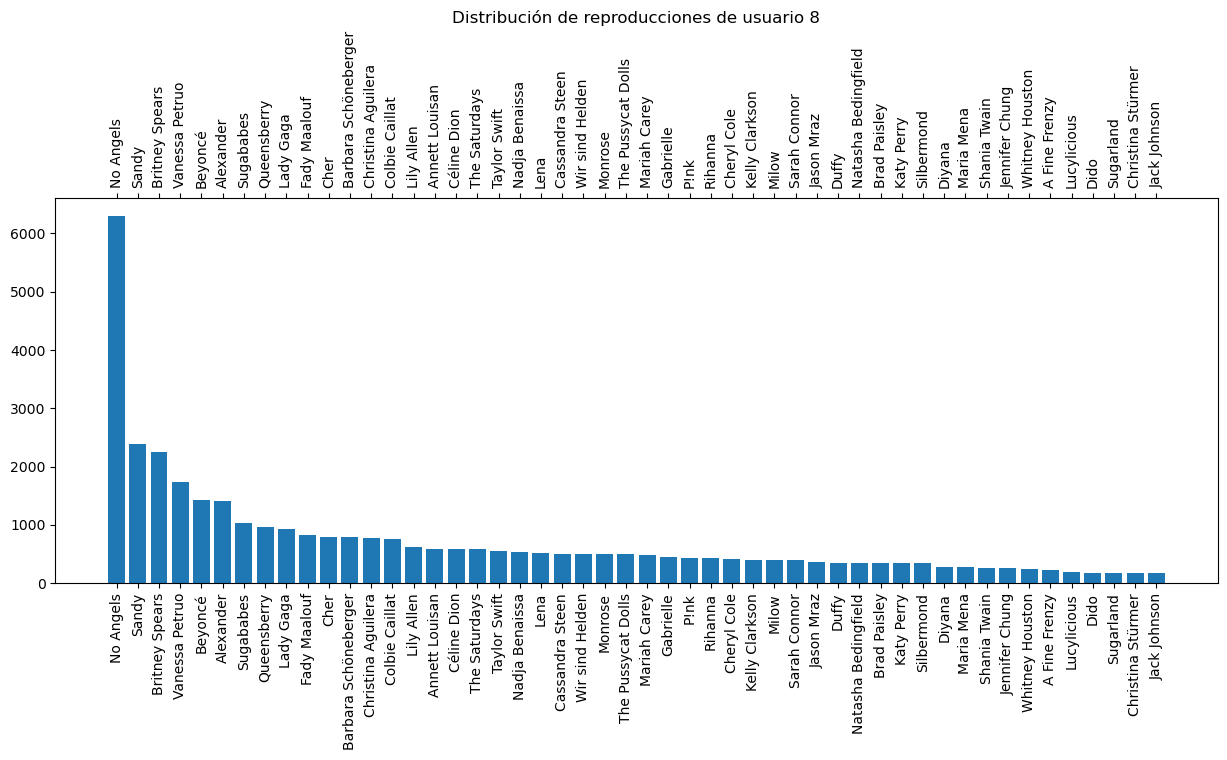

In [103]:
# Distribución de reproducciones de usuario 8
df_user8 = df[df['userID'] == 8]

# Ordenar por reproducciones
df_user8.sort_values(by='nro_reproducciones', ascending=False, inplace=True)

# Graficar distribución de reproducciones de usuario 8
fig, ax = plt.subplots(figsize=(15, 5))
plt.bar(df_user8['name'], df_user8['nro_reproducciones'])
plt.title('Distribución de reproducciones de usuario 8')
plt.xticks(rotation=90)
plt.show()

Para este análisis se filtró dentro del dataframe las reproducciones del usuario 8, se ordenó el número de reproducciones de mayor a menor y se graficó la frecuencia de reproducciones de cada uno de los artistas que escucha este usuario. Dentro de los artistas que se encuentran en la gráfica, se puede ver que en su mayoría son artistas pop y mujeres.

### 3. Generando Recomendaciones

En esta sección nos interesa generar recomendaciones ***nuevas y relevantes*** para el usuario 8 (`userID==8`). Para ello vamos a generar distintos sistemas de recomendación y comparar las recomendaciones generadas.

#### 3.1. Filtrado colaborativo sencillo: promedios simples.

Usando el promedio simple de reproducciones (sin considerar el número de reproducciones) genere una tabla y/o gráfica con 10 recomendaciones de artistas para este usuario. Explique con cuidado su procedimiento y justifique sus elecciones.

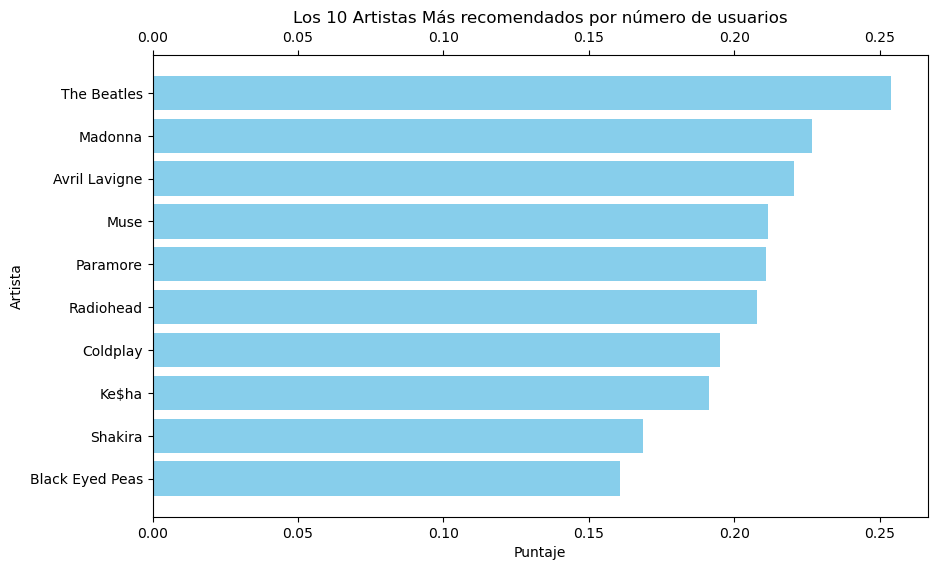

In [104]:
# Se crea la matriz de frecuencias. Si el usuario ha escuchado al artista, se coloca 1, de lo contrario 0
r_matrix = df.pivot_table(values='nro_reproducciones', index='userID', columns='artistID')
r_matrix_dummy = r_matrix.notna().astype(int)
r_matrix_dummy

# Función para calcular la similitud entre usuarios
def cf_user_mean(r_matrix, artistID):
    if artistID in r_matrix:
        mean_rating = r_matrix[artistID].mean()
    else:
        mean_rating = 0
    return mean_rating

# Calcular la similitud entre usuarios
artistID_list = df['artistID'].unique()  
scores = []

for artistID in artistID_list:
    mean_rating = cf_user_mean(r_matrix_dummy, artistID)
    scores.append({"artistID": artistID, "score": mean_rating})

# Función para graficar el rating
def plot_artist_ranking(scores, df_artists, title):
    # Convertir diccionario a dataframe
    scores_df = pd.DataFrame(scores)
    # Agregar las columnas de id de artista y nombre de artista
    scores_df = scores_df.merge(df_artists[['artistID', 'name']], on='artistID', how='left')
    # Agregar el nombre de los artistas que escucha el usuario 8
    scores_df = scores_df.merge(df_user8[['name']], on='name', how='left', indicator=True)
    # Filtrar los artistas que no escucha el usuario 8 para hacerle las recomendaciones
    scores_df = scores_df[scores_df['_merge'] == 'left_only']

    artistas_populares = scores_df.sort_values(by='score', ascending=False).head(10)

    # Crear un gráfico de barras horizontal
    plt.figure(figsize=(10, 6))  # Ajustar el tamaño del gráfico
    plt.barh(artistas_populares['name'], artistas_populares['score'], color='skyblue')
    plt.xlabel('Puntaje')
    plt.ylabel('Artista')
    plt.title(title)
    plt.gca().invert_yaxis()  # Invertir el eje y para mostrar el artista más popular en la parte superior

    # Mostrar el gráfico
    plt.show()

# Graficar el rating
plot_artist_ranking(scores, df_artists, 'Los 10 Artistas Más recomendados por número de usuarios')

De acuerdo a lo indicado en las respuestas de slack a la duda sobre este punto presentada por una compañera el día 9 de septiembre, se utilizó la proporción de usuarios que escucharon un artista en lugar de sus reproducciones. Para esto, se generó una matriz que cruza el id del usuario con el de los artistas y llena los espacios con el número de reproducciones. A continuación, el número de reproducciones se modificó por 1 y los NaN por 0 indicando que el usuario no escuchó al artista. A continuación se definió una función que asigna un rating igual a la proporción de veces que fue escuchado y un puntaje de 0.01 a artistas que no aparecen en la lista inicial. Se realizó el cálculo para el usuario 8 depurando los artistas que él ya escucha con el fin de que las recomendaciones sean nuevas y relevantes. A continuación, se muestran gráficamente las 10 primeras recomendaciones para el usuario.

#### 3.2.  Filtrado colaborativo sencillo: promedios ponderados.

Usando el promedio de reproducciones ponderado por `nro_reproducciones` genere una tabla y/o gráfica con 10 recomendaciones de artistas para este usuario. Explique con cuidado su procedimiento y justifique sus elecciones. Compare las recomendaciones con el sistema implementado en el paso anterior.


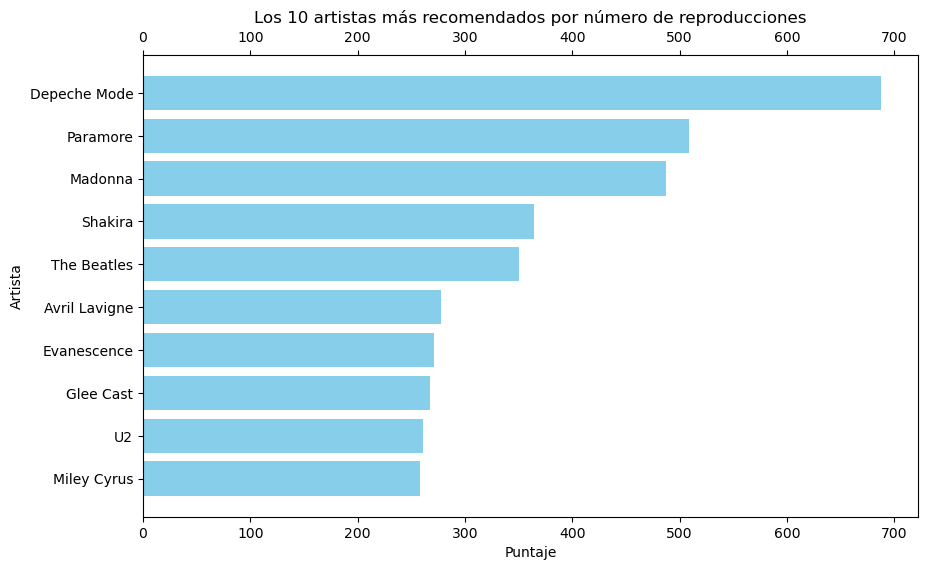

In [105]:
# Tabla con usuarios y número de reproducciones por artista
r_matrix = df.pivot_table(values='nro_reproducciones', index='userID', columns='artistID').fillna(0)

# Reiniciar la lista de scores
scores.clear()

for artistID in artistID_list:
    mean_rating = cf_user_mean(r_matrix, artistID)
    scores.append({"artistID": artistID, "score": mean_rating})

# Graficar el rating
plot_artist_ranking(scores, df_artists, 'Los 10 artistas más recomendados por número de reproducciones')

En este punto, en lugar de usar la proporción de usuarios que escucharon un artista, se usa la proporción de reproducciones, de manera que la matriz usada no es la que tiene máyor proporción de usuarios que la escucharon, sino mayor número de reproducciones promedio entre los usuarios que escucharon al artista. Esto puede hacer que se terminen recomendando artistas que quizás son menos habituales (no tan populares), pero que son sumamente habituales entre los usuarios que los escuchan por tal razón las recomendaciones como Depeche Mode al ser populares en terminos de reproducciones aparece como primera opción lo cual no pasa con el procedimiento anterior ya que no se contemplaba este número para ponderar la recomendación.

#### 3.3.  Filtrado colaborativo sencillo: similitud de coseno.

Usando el promedio ponderado de reproducciones genere una tabla y/o gráfica  con 10 recomendaciones de artistas para este usuario. Para generar los pesos utilice la distancia de coseno. Explique con cuidado su procedimiento y justifique sus elecciones. Compare las recomendaciones con el sistema implementado en el paso anterior.

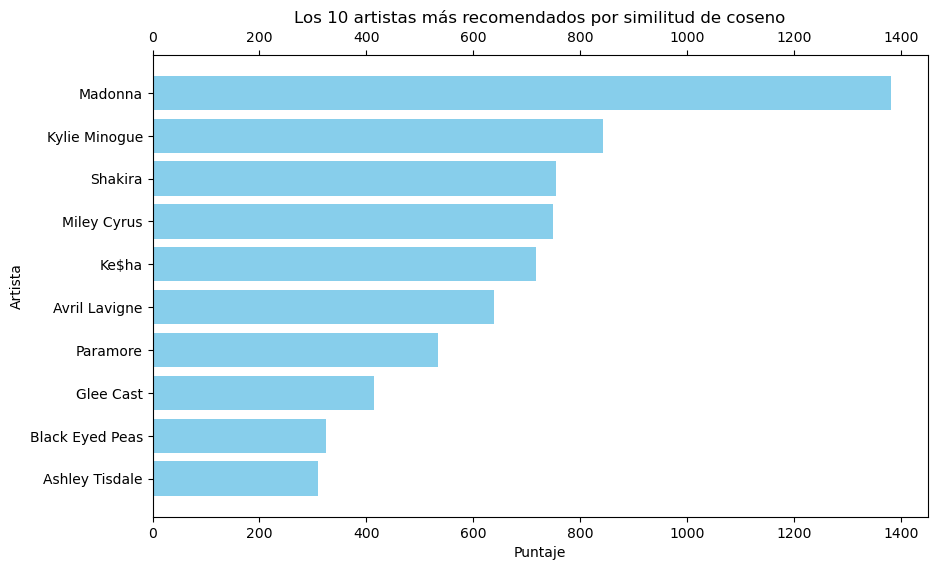

In [106]:
#Calculamos la similitud de coseno 
cosine_sim = cosine_similarity(r_matrix, r_matrix)

# Transformamos la matriz resultante en un dataframe
cosine_sim = pd.DataFrame(cosine_sim, index=r_matrix.index, columns=r_matrix.index)

cosine_sim.head(10)

def cf_user_wmean(user_id, artistID):
    # Primero verificamos si el artista esta en la matriz
    if artistID in r_matrix:
        #Buscamos las medidas de similitud con los otros usuarios
        sim_scores = cosine_sim[user_id]
        # Obtenemos los ratings no faltantes de la matriz bajo evaluación
        m_ratings = r_matrix[artistID]
        # Obtenemos los índicies de los artistas sin rating 
        idx = m_ratings[m_ratings.isnull()].index
        # Nos quedamos con similitudes y ratings completos
        sim_scores = sim_scores.drop(idx)
        m_ratings = m_ratings.dropna()
        # Calculamos la media ponderada
        wmean_rating = np.dot(sim_scores, m_ratings)/ sim_scores.sum()
    else:
        # Si no tenemos ninguna información retornamos 0
        wmean_rating = 0
    
    return wmean_rating

# Calcular la similitud entre usuarios
scores = []

for artistID in artistID_list:
    mean_rating = cf_user_wmean(8, artistID)
    scores.append({"artistID": artistID, "score": mean_rating})

# Graficar el rating
plot_artist_ranking(scores, df_artists, 'Los 10 artistas más recomendados por similitud de coseno')

Con el anterior código se calcula la similitud de coseno entre usuarios con el promedio ponderado de reproducciones y luego utiliza esta similitud para predecir las calificaciones de artistas para el user_id == 8 en este caso. Luego, se genera una lista de puntuaciones para varios artistas y grafica los 10 primeros artistas recomendados para este usuario, con la cual podemos determinar que son recomendaciones de artistas femeninos Pop que son más parecidos entre sí como Madonna, Kylie Minogue, Shakira etc pero que versus el anterior procedimiento de recomendación esto no sucedia en las primeras recomendaciones ya que no se estaba buscando similitud sino pinderacion del npumero de reproducciones de artistas.

#### 3.4.  Filtrado colaborativo usando SVD


Usando la descomposición en valores singulares (SVD) genere una tabla y/o gráfica  con 10 recomendaciones de artistas para este usuario.  Explique con cuidado su procedimiento y justifique sus elecciones. Compare las recomendaciones con el sistema implementado en los pasos anteriores.


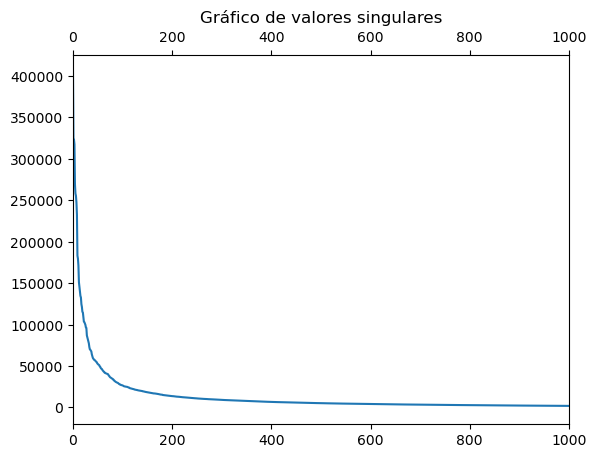

La varianza explicada por los primeros 100 valores singulares es 0.951291


In [107]:
# Pasar a matriz dispersa para poder aplicar SVD
A = r_matrix.to_numpy()
# Calcular la media de las calificaciones de cada usuario
user_ratings_mean = np.mean(A, axis = 1)
# Restar la media de las calificaciones de cada usuario para normalizar
A_demeaned = A - user_ratings_mean.reshape(-1, 1)
# Calcular SVD
U, sigma, Vt = svd(A_demeaned)
# Graficar los valores singulares
x_coordinate = [i for i in range(len(sigma)) ]
plt.plot(x_coordinate,sigma)
plt.title('Gráfico de valores singulares')
plt.xlim(0, 1000)
plt.show()
# Calcular la varianza explicada
var_explained = np.round(sigma**2/np.sum(sigma**2), decimals=6)
vs = 100
print(f'La varianza explicada por los primeros {vs} valores singulares es {sum(var_explained[0:vs])}')

In [108]:
# Calcular la matriz de recomendaciones
U, sigma, Vt = svds(A_demeaned, k = vs)
sigma = np.diag(sigma)
A_recomendaciones = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
recomendac_df = pd.DataFrame(A_recomendaciones, columns = r_matrix.columns)
recomendac_df.head(10)

artistID,1,2,3,4,5,6,7,8,9,10,...,18736,18737,18738,18739,18740,18741,18742,18743,18744,18745
0,2.033813,5.224558,0.650398,1.489550,1.962391,-15.348861,90.160239,18.164756,2.470251,0.960792,...,2.501171,1.989224,1.745287,1.698746,1.604060,1.573568,1.562334,1.551100,1.549495,-0.998452
1,1.194764,1.188069,1.184917,1.185820,1.201188,1.033677,-1.160870,0.727358,1.096808,1.259612,...,1.189457,1.188005,1.187314,1.187182,1.186914,1.186827,1.186795,1.186763,1.186759,1.164497
2,0.689183,0.764240,0.353082,0.425605,0.532978,1.513865,-16.581012,-0.043575,1.348333,2.274401,...,0.402998,0.380830,0.370267,0.368251,0.364151,0.362831,0.362345,0.361858,0.361789,0.181378
3,0.020067,0.296278,-0.058060,0.099957,0.186824,-0.123308,5.046489,-0.513088,2.494495,3.426673,...,-0.038857,-0.044141,-0.046659,-0.047139,-0.048116,-0.048431,-0.048547,-0.048663,-0.048679,0.214308
4,0.048156,0.040642,0.049110,0.048797,0.048883,0.049199,0.600705,0.055137,0.043836,0.051172,...,0.048901,0.049010,0.049063,0.049073,0.049093,0.049099,0.049102,0.049104,0.049105,0.049492
5,-0.876509,-2.670086,-0.715243,-0.565705,-0.823352,-2.525956,-178.816782,-3.205692,-6.936395,-1.130159,...,-0.979791,-0.857930,-0.799865,-0.788787,-0.766248,-0.758990,-0.756316,-0.753642,-0.753260,-0.313330
6,1.120755,1.298576,1.334999,1.298769,1.313603,1.878054,-0.855280,1.087856,1.158459,1.466806,...,1.328846,1.329784,1.330231,1.330316,1.330490,1.330546,1.330567,1.330587,1.330590,1.287740
7,1.148434,1.154687,1.233696,1.101964,1.031252,3.369137,1.747134,8.563406,-1.604402,2.306917,...,1.065645,1.086552,1.096514,1.098414,1.102281,1.103526,1.103985,1.104444,1.104509,1.129360
8,0.994919,0.938152,0.759316,0.881424,0.999748,1.443726,19.857339,3.707931,1.054971,2.962881,...,0.846483,0.818577,0.805280,0.802743,0.797582,0.795920,0.795308,0.794695,0.794608,0.932179
9,1.292727,1.302498,0.430708,0.409558,0.498570,-1.386623,27.681695,3.637578,-0.819332,-0.073769,...,0.359208,0.377344,0.385985,0.387633,0.390987,0.392068,0.392466,0.392864,0.392920,0.394374


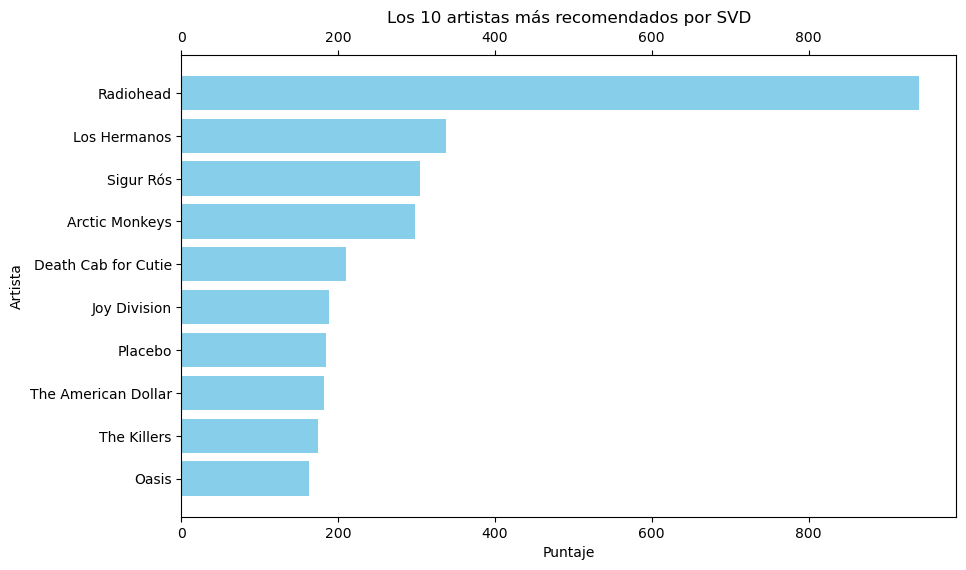

In [109]:
# Obtener la fila de recomendaciones para el usuario 8
user8_recomendations = recomendac_df.abs().iloc[8].sort_values(ascending=False)
user8_recomendations = pd.DataFrame(user8_recomendations).reset_index()
user8_recomendations.rename(columns={8: 'score'}, inplace=True)
plot_artist_ranking(user8_recomendations, df_artists, 'Los 10 artistas más recomendados por SVD')

Para este punto primero se calcula la matriz de valores singulares y se grafica la varianza explicada de esta obteniendo que con 100 valores singulares se explica casi el 95% de la varianza. Seguido a esto se toma como k=100 dado el ejercicio hecho anteriormente y se procede a reconstruir la matriz original obteniendo nuevos puntajes para cada combinación de usuario-artista. Se extrae la fila del usuario 8, se organizan los puntajes en valor absoluto de esta fila y se grafican los primeros 10 que serían las recomendaciones para hacerle al usuario.

#### 3.5.  Filtrado colaborativo usando Análisis de Canasta de Compra

Usando  el algoritmo `Apriori` genere una tabla y/o gráfica  con 10 recomendaciones de artistas para este usuario.  Explique con cuidado su procedimiento y justifique sus elecciones. Compare las recomendaciones con el sistema implementado en los pasos anteriores. Esto puede tomar mucho tiempo, sea cuidadoso al elegir los hiper-parámetors del modelo, utilice los resultados de las estadísticas descriptivas para elegir sus hier-parámetros, y genere solo reglas con 2 elementos. (Puede también aprovechar los recursos de [Google Colab](https://colab.research.google.com/))


Inicialmente cargamos la libreria apriori y tomamos el dataframe original con toda la información para realizar una lista y posteriomente correr el algoritmo apriori con los parametos de Min_support del 5%, min_confidence al 50% y que tenga un lift minimo de 2. Esto se decidió arbitariamente para poder encontrar suficientes reglas y de allí determinar cuales podrian ser las mejores para el usuario 8. De las 384 reglas encontradas filtramos estas por los artistas que oye y también filtramos por los artistas que no oye para poder tener nuevas recomendaciones para este usuario que sean de su agrado ordenandolas por la metrica de support la cual nos indica que tan frecuente estas combinaciones de artistas aparecen.

In [110]:
from apyori import apriori

Se encontraron 348 reglas de asociación


,From,To,Support,Confidence,Lift,FromN,ToN,name,_merge
11,P!nk,Madonna,0.093552,0.580328,2.559395,19,6,NaN,left_only
9,Rihanna,Hilary Duff,0.075581,0.846154,3.307692,33,29,NaN,left_only
5,Rihanna,Nelly Furtado,0.075053,0.881988,3.447770,33,5,NaN,left_only
8,Rihanna,Leona Lewis,0.075053,0.887500,3.469318,33,3,NaN,left_only
3,Taylor Swift,Paramore,0.072410,0.554656,2.630098,16,10,NaN,left_only
6,Rihanna,Lindsay Lohan,0.059725,0.904000,3.533818,33,8,NaN,left_only
7,Rihanna,Pixie Lott,0.054968,0.881356,3.445300,33,28,NaN,left_only
12,P!nk,Nelly Furtado,0.052854,0.621118,3.852968,19,5,NaN,left_only


C:\Users\Daniel Rozo\AppData\Local\Temp\ipykernel_13968\3198022209.py:65: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb = plt.colorbar(plt.cm.ScalarMappable(cmap='viridis'))


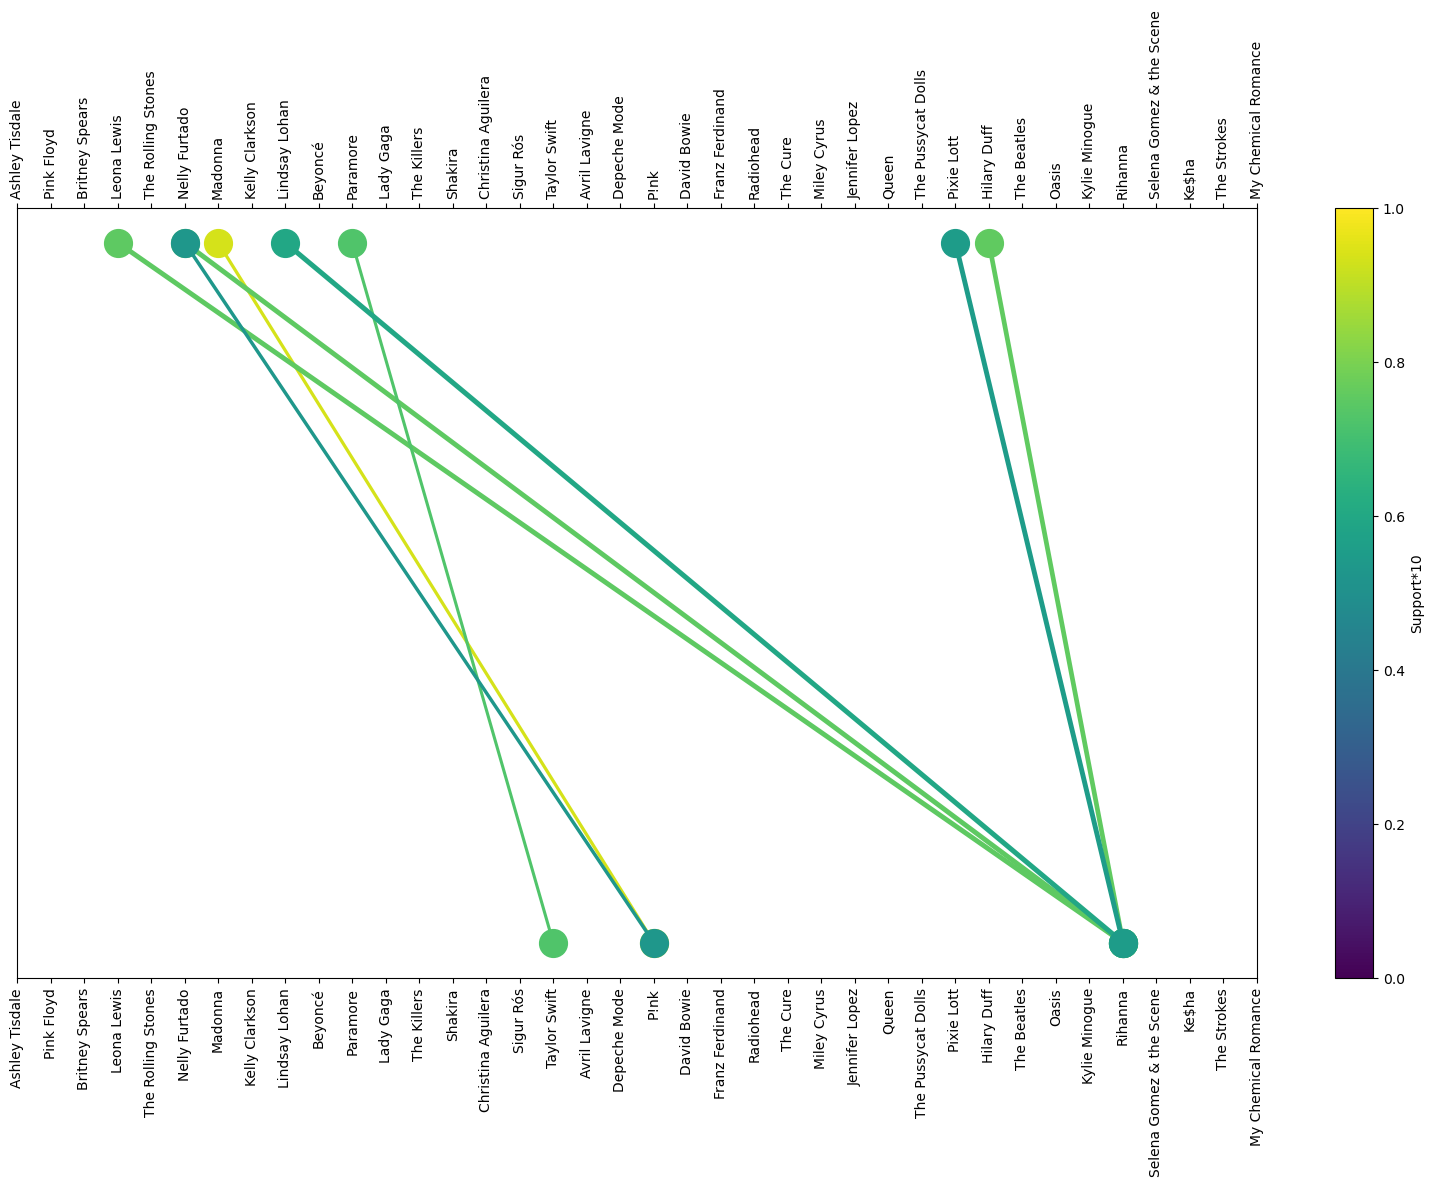

In [149]:
# Obtener lista de listas
records = []
for i in df['userID'].unique():
    records.append(list(df[df['userID'] == i]['name'].values)) # Extendemos la lista en lugar de agregar sublistas

# Guardar las reglas de apriori en la variable de reglas
rules = list(apriori(
    records,
    min_support=0.05,
    min_confidence = 0.5,
    min_lift=2,
    max_length=2))

print(f'Se encontraron {len(rules)} reglas de asociación')

# Convertir la lista de reglas en dataframe
rules_df = pd.DataFrame(
    [{'From': list(rule[0])[0],
     'To': list(rule[0])[1],
     'Support': rule[1],
     'Confidence': rule[2][0][2],
     'Lift': rule[2][0][3]} for rule in rules if len(rule[0]) == 2])

rules_df = rules_df.dropna()

# Tomar las reglas top
rules_df = rules_df.sort_values('From', ascending=False).head(50)

# listar todos los artistas
items = set(rules_df['From']) | set(rules_df['To'])

# Crear Mapping de los SKUS en numeros
imap = {item : i for i, item in enumerate(items)}

# Mapear los artistas en numeros y adicione numerica del from a to en columnas
rules_df['FromN'] = rules_df['From'].map(imap)
rules_df['ToN'] = rules_df['To'].map(imap)

# Filtrar en las reglas de asociación los artistas que escucha el usuario 8
rules_df = rules_df[rules_df['From'].isin(df_user8['name'])]

# Filtrar las recomendaciones que el usuario 8 no escucha
artist_filtered = pd.merge(rules_df, df_user8[['name']], left_on='To', right_on='name', how='left', indicator=True)
artist_filtered = artist_filtered[artist_filtered['_merge'] == 'left_only']

# Ordenar las reglas de asociación por support
artist_filtered.sort_values('Support', ascending=False, inplace=True)
display(artist_filtered.head(10))

# Graficar reglas de asociación
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

# Establecer tamaño de la grafica
fig = plt.figure(figsize=(20,10))

# Dibujar las lineas entre los artistas
# colores para cada linea segun el support de la regla
for index, row in artist_filtered.head(10).iterrows():
    plt.plot([row['FromN'], row['ToN']], [0, 1], 'o-',
             c=plt.cm.viridis(row['Support'] * 10),
             markersize=20,
             lw=row['Confidence'] * 4)


cb = plt.colorbar(plt.cm.ScalarMappable(cmap='viridis'))
cb.set_label('Support*10')

plt.xticks(range(len(items)), items, rotation= 'vertical', fontsize=10)
plt.yticks([])
plt.show()

Con la anterior grafica la cual resumen las 8 reglas encontradas para este usuario usando Apriori, podemos determinar que viendo la parte inferior donde estos son los artistas del from y la parte superior son los artistas del To podemos recomendar con mayor probabilidad de que pase para este usuario es que al Oir Pink se le pueda recomendar posteriormente oir Madonna la cual es la que se ve con una linea más amarilla y tiene mayor support que las demas reglas. Este tipo de sistema de recomendación versus los anteriores puede ayudar a determinar una lista de reproducción para el usuario según lo que oye actualmente que incluso tengamos opciones distintas como por ejemplo tener 5 recomendaciones diferentes si oye Rihanna --> (Hillary, Nelly, Leona, Lindsay, Pixie) con los anteriores no teniamos esa posibilidad de hacerlo.

### 4. Recomendaciones generales 

De acuerdo con los resultados encontrados, en su opinión ¿qué procedimiento generó las mejores recomendaciones para este usuario? ¿Cómo implementaría una evaluación objetiva de estas recomendaciones? Justifique su respuesta.

En conclusión, podemos inferir que no hay ningun procedimiento que generó las mejores recomendaciones sino que todas las maneras ayudan a complementar las recomendaciones para enriquecer la experiencia al usuario. Entonces lo mejor es saber que objetivo cumple los diferentes metodos. En un ejemplo más concreto podriamos hacer lo siguiente para poner un objetivo a cada sistema de recomendación:

1. Filtrado colaborativo sencillo: promedios simples: Ayuda a tener en cuenta la popularidad de los artistas en base a todos los usuarios lo cual puede ayudar que la persona oiga lo que muchos otros usuarios estan oyendo en la plataforma y salirse un poco de sus preferencias personales.

2. Filtrado colaborativo sencillo: promedios ponderados. Este sistema de recomendación ayudaría a ponderar los artistas no solo por los usuarios que los oyen sino por su número de reproducciones. Es decir que este sistema tiene en cuenta que tan populares y frecuentes en sus reproducción pues ya tendria una segunda dimensión que complementaria enormemente el primer sistema.

3. Filtrado colaborativo sencillo: similitud de coseno. Este sistema al tener en cuenta artistas similares que este oyé y ayudaria a que el usuario pudiera encontrar artistas nuevos que podrian ser de sus gusto al estar muy cerca a sus preferencias musicales. Siendo un sistema practicamente opuesto al filtrado sencillo ya que el primero abarca todos los usuarios mientras este se enfoca en lo gustos personales actuales.

4. Filtrado colaborativo usando Análisis de Canasta de Compra: Este sistema podria ayudar a encontrar listas de reproducción totalmente según lo que actualmente esta oyendo en la plataforma de música en donde podriamos tener diferentes opciones según el artista que oye.

Por ultimo para saber como implementar una evaluación más objetiva de cada sistema de recomendación seria hacer al menos lo siguiente:

- Dividir los datos en conjuntos de train & test
- Definir una metrica de evaluación como RMSE el cual vimos en los cuadernos teoricos de los sistemas de recomendación.
- Evaluar cada enfoque por separado en test.
- Realizar las comparaciones y sacar conclusiones de cada uno de manera objetiva